# Итоги

Итоги приведу в начале, чтобы избавить от необходимости листать файл до конца)

Наилучшие результаты были получены нейросетью с одним скрытым слоем из 64 нейронов. Использованные признаки:


*   текст объявления (description). Для представления текста использовал tfidf (max_features=100000,ngram_range=(1, 2))
*   текст заголовков (title). Тоже tfidf, но max_features=10000. Заголовки кроме того были очищены от знаков препинания и цифр
*   цена и новые признаки: количество слов в заголовке и количество слов в тексте объявления. Эти данные были нормализованы с помощью StandardScaler, т.к. из-за широкого разброса цен точность падала до 8-10%


Также была рассчитана точность на разных уровнях иерархии (как я понял их 4)

*   Точность на 1 уровне: 0.9575
*   Точность на 2 уровне: 0.9359
*   Точность на 3 уровне: 0.8795
*   Точность на 4 уровне: 0.8754 (итоговая точность)

При подсчете точности тренировочные данные - это 70% данных из train.csv, а тестовые - оставшиеся 30%



# Загрузка файлов (Colaboratory)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

    100% |████████████████████████████████| 993kB 22.2MB/s 


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1yP6LE6hbS8nICho0W7KLqoicYu4PEeA8'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train.csv')

In [0]:
file_id = '1CjI3HQsB3Cma2SrTMLJ9PUvSHCK9r_Lp'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test.csv')

In [0]:
file_id = '1rkxPEPPICEu99JchWDBVKsYCFstSRWQF'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('category.csv')

# Импорт библиотек

In [0]:
from collections import defaultdict

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import np_utils

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack

import re
from nltk.corpus import stopwords
import string
import nltk


from tqdm import tqdm_notebook

import warnings
warnings.simplefilter('ignore')

In [0]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Осмотр данных

In [0]:
category = pd.read_csv('category.csv', index_col='category_id')
category.head(10)

,name
category_id,
0,Бытовая электроника|Телефоны|iPhone
1,Бытовая электроника|Ноутбуки
2,Бытовая электроника|Телефоны|Samsung
3,Бытовая электроника|Планшеты и электронные кни...
4,"Бытовая электроника|Игры, приставки и программ..."
5,Бытовая электроника|Аудио и видео|Телевизоры и...
6,Бытовая электроника|Телефоны|Другие марки
7,Бытовая электроника|Настольные компьютеры
8,"Бытовая электроника|Игры, приставки и программ..."


In [0]:
category.shape

(54, 1)

In [0]:
test_df = pd.read_csv('test.csv', index_col='item_id')
test_df.head(10)

,title,description,price
item_id,,,
489517,Стоик журнальный сталь,продам журнальный столик изготавливаю столы из...,10000.0
489518,iPhone 5 64Gb,"Телефон в хорошем состоянии. Комплект, гаранти...",12500.0
489519,Утеплитель,ТЕПЛОПЕЛЕН-ЛИДЕР ТЕПЛА!!! Толщина утеплителя :...,250.0
489520,Пальто демисезонное,Продам пальто женское (букле) в отличном состо...,1700.0
489521,Samsung syncmaster T200N,"Условно рабочий, проблема в панели настройки м...",1000.0
489522,Дверь Profil Doors Х21,Дверь межкомнатная ProfilDoors 21Х. Серия Х пр...,6600.0
489523,"Новый Cort CR100 в отличном состоянии, с коробкой","Доброго времени суток, Томичи. Срочно нужны де...",13900.0
489524,Кресла,Продаются 2кресла в хорошем состоянии за два 600,600.0
489525,Сверх быстрый YotaPhone 2,"Да , разбит дисплей , но когда экран работает ...",6000.0


In [0]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243166 entries, 489517 to 732682
Data columns (total 3 columns):
title          243166 non-null object
description    243166 non-null object
price          243166 non-null float64
dtypes: float64(1), object(2)
memory usage: 7.4+ MB


In [0]:
train_df = pd.read_csv('train.csv', index_col='item_id')
train_df.head(10)

,title,description,price,category_id
item_id,,,,
0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22
2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37
3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43
4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1
5,Бас гитара invasion bg110,Состояние хорошее. Имеется теплый чехол .,3999.0,50
6,"Смесь ""Грудничок"" г. Зеленодольск",Смесь молочная адаптированная ультрапастеризов...,15.0,41
7,G-shock,Часы абсолютно новые! с коробкой. Часы Китай...,2500.0,36
8,"Санатории Белоруссии. - ""Лепельский военный""",Санатории Белоруссии! - «Лепельский военный» ...,1090.0,48


In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489517 entries, 0 to 489516
Data columns (total 4 columns):
title          489517 non-null object
description    489517 non-null object
price          489517 non-null float64
category_id    489517 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 18.7+ MB


In [0]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,489517.0,8795.969966,71581.944044,13.0,750.0,2400.0,7000.0,10000000.0
category_id,489517.0,26.765361,15.531774,0.0,13.0,27.0,40.0,53.0


Посмотрим на распределение объявлений по категориям

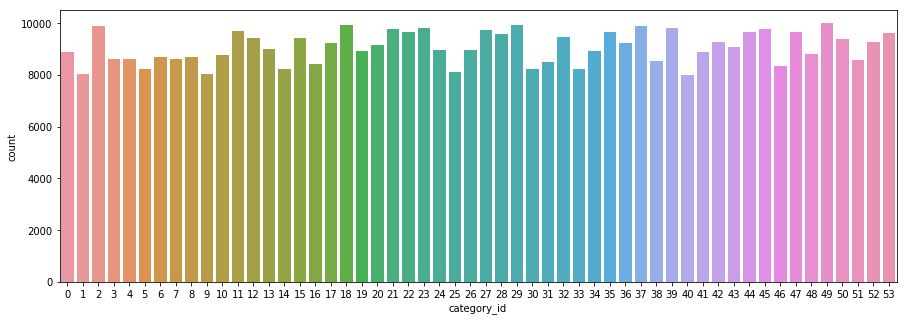

In [0]:
plt.figure(figsize=(15, 5))
sns.countplot(train_df.category_id)

Посмотрим на цены

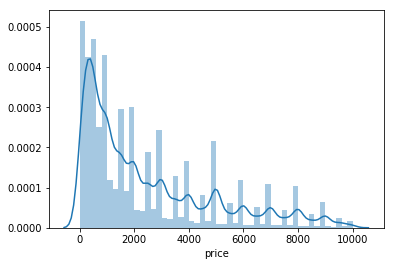

In [0]:
sns.distplot(train_df.price[train_df.price<10000])

Добавим новые признаки - длина заголовка и текста объявления

In [0]:
train_df['title_len'] = train_df.title.map(lambda x: len(x.split()))
train_df['descr_len'] = train_df.description.map(lambda x: len(x.split()))
train_df.head()

,title,description,price,category_id,title_len,descr_len
item_id,,,,,,
0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,1,3
1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,4,11
2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,3,102
3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,6,234
4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,2,18


In [0]:
test_df['title_len'] = test_df.title.map(lambda x: len(x.split()))
test_df['descr_len'] = test_df.description.map(lambda x: len(x.split()))

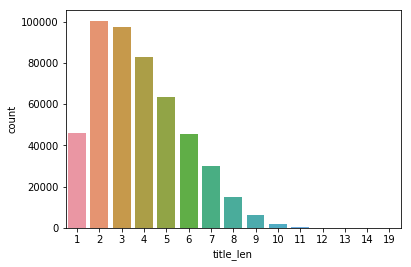

In [0]:
sns.countplot(train_df['title_len']);

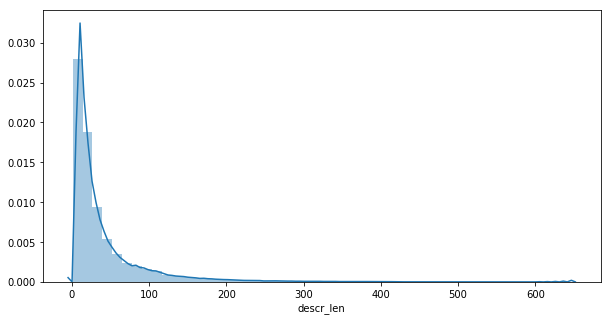

In [0]:
plt.figure(figsize=(10, 5))
sns.distplot(train_df['descr_len']);

# Модель 1

Только description

## Работа с текстом

In [0]:
n_features = 100000

In [0]:
tf_idf_descr = TfidfVectorizer(max_features=n_features,ngram_range=(1, 2))
x_train_descr = tf_idf_descr.fit_transform(train_df.description.values)

## Подготовка датасета

In [0]:
target = train_df.category_id
x_train, x_test, y_train, y_test = train_test_split(x_train_descr, target, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape)

(342661, 100000) (146856, 100000)


## Модели

In [0]:
models = {'decision tree': DecisionTreeClassifier(max_depth=3),
          'random forest': RandomForestClassifier(),
          'naive bayes': MultinomialNB(),
          'sgd': SGDClassifier(loss='modified_huber'),
         }

In [0]:
for key, model in models.items():
  model.fit(x_train, y_train)
  predicted = model.predict(x_test)
  print('%s %.4f' % (key, accuracy_score(y_test, predicted)))

decision tree 0.0575


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


random forest 0.6745
naive bayes 0.7542


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


sgd 0.7809


In [0]:
seed = 7
np.random.seed(seed)

def create_model():
  model = Sequential()
  model.add(Dense(64, activation='relu', input_dim=n_features))
  model.add(Dropout(0.2))
  model.add(Dense(54, activation='softmax'))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model


model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=32, verbose=1)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(model, x_train_descr, target, cv=kfold, scoring='accuracy', verbose=1)
print(results.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
326329/326329 [==============================] - 235s 719us/step - loss: 1.1070 - acc: 0.7344
Epoch 2/3
326329/326329 [==============================] - 240s 734us/step - loss: 0.5651 - acc: 0.8386
Epoch 3/3
163188/163188 [==============================] - 83s 506us/step
Epoch 1/3
326340/326340 [==============================] - 243s 745us/step - loss: 1.1151 - acc: 0.7327
Epoch 2/3
326340/326340 [==============================] - 243s 746us/step - loss: 0.5685 - acc: 0.8377
Epoch 3/3
163177/163177 [==============================] - 86s 526us/step
Epoch 1/3
326365/326365 [==============================] - 254s 779us/step - loss: 1.1130 - acc: 0.7328
Epoch 2/3
326365/326365 [==============================] - 250s 766us/step - loss: 0.5682 - acc: 0.8377
Epoch 3/3
163152/163152 [==============================] - 85s 524us/step
0.7909551922543443


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 41.0min finished


**Подведем итоги**

decision tree 0.0575

random forest 0.6745

naive bayes 0.7542

sgd 0.7809

nn 1L 64n 2L 32n 0.7778

**nn 1L 64n 0.7909**

# Модель 2

description+чистка текста

## Работа с текстом

In [0]:
def tokenize_me(file_text):
  
  tokens = nltk.word_tokenize(file_text)
  
  tokens = [i for i in tokens if ( i not in string.punctuation )]
  
  stop_words = stopwords.words('russian')
  stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на', 'п', 'рф', 'ред', 'г', 'ооо', 'ст', 'гк', 'здравствуйте', 'из-за', '–'])
  tokens = [i for i in tokens if ( i not in stop_words )]
  
  tokens = [i.replace("«", "").replace("»", "") for i in tokens]
  tokens = [i.replace("“", "").replace("”", "") for i in tokens]
  tokens = [i.replace("`", "") for i in tokens]
  tokens = [i.replace("'", "") for i in tokens]
  tokens = [i.replace("ё", "е") for i in tokens]
  
  return tokens

In [0]:
def text_cleaner(text):
  clean = []
  for s in tqdm_notebook(text):
    t = ""
    t = re.sub('(E-mail\S+)', "", s)
    t = re.sub('(@\S+)', "", t)
    t = re.sub('(№\S+)', "", t)
    t = re.sub('(№)', "", t)
    t = re.sub('(\*\S+)', "", t)
    t = re.sub('\.', " ", t)
    t = re.sub('  ', " ", t)
    t = re.sub('(#\w+)|(@\w+)|(\d+)|(&gt;)|(&lt;)', "", t)

    t = t.lower()

    s = ""
    for w in tokenize_me(t):
      s = s + ' ' + w

    t = s
    t = re.sub('  ', " ", t)

    t = t.strip()



    clean.append(t)
  return clean

In [0]:
text = train_df.description.values
clean = text_cleaner(text)

In [0]:
n_features = 100000

tf_idf_descr = TfidfVectorizer(max_features=n_features,ngram_range=(1, 2))
x_train_descr = tf_idf_descr.fit_transform(clean)

## Подготовка датасета

In [0]:
target = train_df.category_id
x_train, x_test, y_train, y_testd = train_test_split(x_train_descr, target, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape)

(342661, 100000) (146856, 100000)


## Модели

Попробуем лучшие модели с предыдущего шага

In [0]:
models = {'naive bayes': MultinomialNB(),
          'sgd': SGDClassifier(loss='modified_huber'),
         }

In [0]:
for key, model in models.items():
  model.fit(x_train, y_train)
  predicted = model.predict(x_test)
  print('%s %.4f' % (key, accuracy_score(test, predicted)))

naive bayes 0.7598


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


sgd 0.7789


Также посмотрим на sgd на кросс-валидации

In [0]:
model = SGDClassifier(loss='modified_huber')
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = cross_val_score(model, x_train_descr, target, cv=kfold, scoring='accuracy', verbose=1)
print(results.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7789310768551099


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min finished


naive bayes 0.7598

sgd 0.7789

sgd cv 0.7789

Теперь посмотрим на разные сочитания слоев нейронных сетей. Опять же на кросс-валидации

In [0]:
seed = 7
np.random.seed(seed)

In [0]:
def create_model():
  model = Sequential()
  model.add(Dense(64, activation='relu', input_dim=n_features))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(54, activation='softmax'))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model


model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=32, verbose=1)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(model, x_train_descr, target, cv=kfold, scoring='accuracy', verbose=1)
print(results.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
326329/326329 [==============================] - 223s 682us/step - loss: 1.2871 - acc: 0.6696
Epoch 2/3
326329/326329 [==============================] - 221s 678us/step - loss: 0.7839 - acc: 0.7851
Epoch 3/3
163188/163188 [==============================] - 80s 490us/step
Epoch 1/3
326340/326340 [==============================] - 227s 696us/step - loss: 1.3073 - acc: 0.6668
Epoch 2/3
326340/326340 [==============================] - 226s 692us/step - loss: 0.7913 - acc: 0.7842
Epoch 3/3
163177/163177 [==============================] - 82s 503us/step
Epoch 1/3
326365/326365 [==============================] - 237s 725us/step - loss: 1.2834 - acc: 0.6698
Epoch 2/3
326365/326365 [==============================] - 235s 719us/step - loss: 0.7811 - acc: 0.7857
Epoch 3/3
163152/163152 [==============================] - 72s 444us/step
0.7768678759325937


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 38.2min finished


NN 1L 32n 0.7884

NN 1L 64n 0.7892

NN 1L 128n 0.7864

NN 1L 64n 2L 32n 0.7768

Видим, что лучший результат (0.7909) показала нейросеть с одним слоем из 64 нейронов на неочищенном тексте. Далее добавим заговолки объявлений и другие признаки (цена, длина текста). Хотя смущает то, что разница точности на тренировке и валидации в случае неочищенного текста в почти в раза выше (4% против 8%). 

# Модель 3

description+title. Попробуем варианты с очищенным и неочищенным текстом

## Работа с текстом

In [0]:
n_features_d = 100000
n_features_t = 10000

Текст объявления

In [0]:
text = train_df.description.values
#text = text_cleaner(text)
tf_idf_descr = TfidfVectorizer(max_features=n_features_d,ngram_range=(1, 2))
x_train_descr = tf_idf_descr.fit_transform(text)

Теперь заголовок

In [0]:
text = train_df.title.values
text = text_cleaner(text)
tf_idf_title = TfidfVectorizer(max_features=n_features_t,ngram_range=(1, 2))
x_train_title = tf_idf_title.fit_transform(text)

## Подготовка датасета

In [0]:
x_train_full = hstack([
                         x_train_descr, 
                         x_train_title,
    
]).tocsr()

In [0]:
target = train_df.category_id

## Модели

Далее будем пробовать только нейронные сети

In [0]:
seed = 7
np.random.seed(seed)

def create_model():
  model = Sequential()
  model.add(Dense(64, activation='relu', input_dim=n_features_d+n_features_t))
  model.add(Dropout(0.2))
  model.add(Dense(54, activation='softmax'))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model


model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=32, verbose=1)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(model, x_train_full, target, cv=kfold, scoring='accuracy', verbose=1)
print(results.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
326329/326329 [==============================] - 234s 716us/step - loss: 0.6907 - acc: 0.8445
Epoch 2/3
326329/326329 [==============================] - 232s 711us/step - loss: 0.2975 - acc: 0.9126
Epoch 3/3
163188/163188 [==============================] - 77s 474us/step
Epoch 1/3
326340/326340 [==============================] - 232s 711us/step - loss: 0.6961 - acc: 0.8430
Epoch 2/3
326340/326340 [==============================] - 232s 711us/step - loss: 0.2987 - acc: 0.9123
Epoch 3/3
163177/163177 [==============================] - 77s 474us/step
Epoch 1/3
326365/326365 [==============================] - 234s 718us/step - loss: 0.6951 - acc: 0.8422
Epoch 2/3
326365/326365 [==============================] - 233s 715us/step - loss: 0.2990 - acc: 0.9122
Epoch 3/3
163152/163152 [==============================] - 79s 484us/step
0.8755365656785054


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 38.9min finished


**Подведем итоги**


неочищенный текст и заголовки nn 1L 64n 0.8750 (0,938 на обучении)

очищенный текст + очищенные заголовки nn 1L 64n 0.8754 (0,933-4 на обучении)

неочищенный текст и очищенные заголовки nn 1L 64n 0.8755 (0,938 на обучении)

# Модель 4

Добавим цену и попробуем добавить длину заголовка и текста объявления

## Работа с текстом

In [0]:
n_features_d = 100000
n_features_t = 10000

Текст объявления

In [0]:
text = train_df.description.values
#text = text_cleaner(text)
tf_idf_descr = TfidfVectorizer(max_features=n_features_d,ngram_range=(1, 2))
x_train_descr = tf_idf_descr.fit_transform(text)

Теперь заголовок

In [0]:
text = train_df.title.values
text = text_cleaner(text)
tf_idf_title = TfidfVectorizer(max_features=n_features_t,ngram_range=(1, 2))
x_train_title = tf_idf_title.fit_transform(text)

## Подготовка датасета

Без нормализации точность сети падала до 10%, поэтому добавим нормализацию

In [0]:
train_tmp_scaled = StandardScaler().fit_transform(train_df[['price', 'descr_len', 'title_len']])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
x_train_full = hstack([x_train_descr, 
                       x_train_title,
                       train_tmp_scaled   
]).tocsr()

In [0]:
target = train_df.category_id

## Модели

In [0]:
seed = 7
np.random.seed(seed)

def create_model():
  model = Sequential()
  model.add(Dense(64, activation='relu', input_dim=n_features_d+n_features_t+3))
  model.add(Dropout(0.2))
  model.add(Dense(54, activation='softmax'))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model


model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=32, verbose=1)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(model, x_train_full, target, cv=kfold, scoring='accuracy', verbose=1)
print(results.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
326329/326329 [==============================] - 268s 822us/step - loss: 0.6955 - acc: 0.8425
Epoch 2/3
326329/326329 [==============================] - 268s 822us/step - loss: 0.2996 - acc: 0.9122
Epoch 3/3
163188/163188 [==============================] - 92s 564us/step
Epoch 1/3
326340/326340 [==============================] - 270s 828us/step - loss: 0.7031 - acc: 0.8402
Epoch 2/3
326340/326340 [==============================] - 269s 825us/step - loss: 0.3007 - acc: 0.9118
Epoch 3/3
163177/163177 [==============================] - 92s 566us/step
Epoch 1/3
326365/326365 [==============================] - 273s 837us/step - loss: 0.7005 - acc: 0.8401
Epoch 2/3
326365/326365 [==============================] - 272s 835us/step - loss: 0.3005 - acc: 0.9115
Epoch 3/3
163152/163152 [==============================] - 95s 581us/step
0.8760145925659734


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 45.3min finished


## Подведем итоги

неочищенный текст и заголовки nn 1L 64n 0.8750 (0,938 на обучении)

очищенный текст + очищенные заголовки nn 1L 64n 0.8754 (0,933-4 на обучении)

неочищенный текст и очищенные заголовки nn 1L 64n 0.8755 (0,938 на обучении)

неочищенный текст и очищенные заголовки + scaled price nn 1L 64n 0.8756 (0,938 на обучении)

**неочищенный текст и очищенные заголовки + scaled price, длина текста и заголовка nn 1L 64n 0.8760 (0,938 на обучении)**

# Подсчет точности на разных уровнях


In [0]:
def get_level_ids(target_level, category_path='category.csv'):
  '''
  Возвращает словарь, в котором ключи - это оригинальные 54 категории, а значения-
  новые категории, соотвествующие указанному уровню иерархии категорий target_level
  '''
  
  
  #считаем файлик с категориями
  category = pd.read_csv(category_path)
  
  #сделаем словарь категорий. Укажем:
  #level - уровень категории
  #max_level - максимальный уровень в текущей ветке каталога
  #ids - id, соответствующие текущей категории
  category_dict = defaultdict(lambda :{ 'level':0, 'max_level':0, 'ids':[] })
  count=0
  for cat_id, path in category.values:
    for level_id, cat_name in enumerate(path.split('|'), 1):
      if cat_name in ['Другое', 'Аксессуары']:
        cat_name = "%s_%d" % (cat_name, count)
        count+=1
      category_dict[cat_name]['level'] = level_id
      category_dict[cat_name]['max_level'] = len(path.split('|'))
      category_dict[cat_name]['ids'].append(cat_id)
  
  #теперь отберем нужные id
  data = []
  count = 0
  for v in category_dict.values():
    if v['level'] == target_level:
      data.append([count, v['ids']])
      count += 1
    elif v['level'] <= target_level and v['level'] == v['max_level']:
      data.append([count, v['ids']])
      count += 1
  
  #для удобства оформим все в виде словаря
  data_dict = dict()
  for cat, cat_ids in data:
    for i in cat_ids:
      data_dict[i] = cat
  
  return data_dict   

In [0]:
def convert_pred(pred_list, level):
  '''
  Выполняет конвертирование списка целей pred_list в новый 
  список целей, соответствующий указанному level
  '''
  cat_dict = get_level_ids(level)
  for k in range(len(pred_list)):
    pred_list[k] = cat_dict[pred_list[k]]
  return pred_list

In [0]:
get_level_ids(1)

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 2,
 31: 2,
 32: 2,
 33: 2,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 39: 2,
 40: 2,
 41: 2,
 42: 3,
 43: 3,
 44: 3,
 45: 3,
 46: 3,
 47: 3,
 48: 3,
 49: 3,
 50: 3,
 51: 3,
 52: 3,
 53: 3}

## Работа с текстом

In [0]:
n_features_d = 100000
n_features_t = 10000

Текст объявления

In [0]:
tf_idf_descr = TfidfVectorizer(max_features=n_features_d,ngram_range=(1, 2))
x_train_descr = tf_idf_descr.fit_transform(train_df.description.values)

Теперь заголовок

In [0]:
text = text_cleaner(train_df.title.values)
tf_idf_title = TfidfVectorizer(max_features=n_features_t,ngram_range=(1, 2))
x_train_title = tf_idf_title.fit_transform(text)

## Подготовка датасета

In [0]:
target_cols = ['price', 'descr_len', 'title_len']
train_tmp_scaled = StandardScaler().fit_transform(train_df[target_cols])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
x_train_full = hstack([
                         x_train_descr, 
                         x_train_title,
                         train_tmp_scaled   
]).tocsr()

In [0]:
target = train_df.category_id
x_train, x_test, y_train, y_test = train_test_split(x_train_full, target, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape)

(342661, 110003) (146856, 110003)


## Модели

In [0]:
seed = 7
np.random.seed(seed)

# подготовим вектор целей для тренировки
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
dummy_y = np_utils.to_categorical(encoded_Y)

n_features = n_features_d + n_features_t + len(target_cols)
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=n_features))
model.add(Dropout(0.2))
model.add(Dense(54, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, dummy_y, 
          validation_data=None,
          batch_size=32,
          epochs=3)


Epoch 1/3
342661/342661 [==============================] - 283s 826us/step - loss: 0.6856 - acc: 0.8419
Epoch 2/3
342661/342661 [==============================] - 276s 806us/step - loss: 0.2994 - acc: 0.9117
Epoch 3/3
342661/342661 [==============================] - 274s 799us/step - loss: 0.2100 - acc: 0.9370


In [0]:
original_pred = model.predict_classes(x_test)
print(accuracy_score(y_test, original_pred))

0.8754289916653047


In [0]:
for i in range(1, 5):
  new_pred = convert_pred(original_pred.copy(), i)
  new_target = convert_pred(y_test.values.copy(), i)  
  print('Точность на %d уровне: %.4f' % (i, accuracy_score(new_target, new_pred)))

Точность на 1 уровне: 0.9575
Точность на 2 уровне: 0.9359
Точность на 3 уровне: 0.8795
Точность на 4 уровне: 0.8754


# Создание файла с ответами

## Работа с текстом

In [0]:
n_features_d = 100000
n_features_t = 10000

Текст объявления

In [0]:
tf_idf_descr = TfidfVectorizer(max_features=n_features_d,ngram_range=(1, 2))
x_train_descr = tf_idf_descr.fit_transform(train_df.description.values)
x_test_descr = tf_idf_descr.transform(test_df.description.values)

Теперь заголовоки

In [0]:
text = text_cleaner(train_df.title.values)
tf_idf_title = TfidfVectorizer(max_features=n_features_t,ngram_range=(1, 2))
x_train_title = tf_idf_title.fit_transform(text)

text = text_cleaner(test_df.title.values)
x_test_title = tf_idf_title.transform(text)

## Подготовка датасета

In [0]:
target_cols = ['price', 'descr_len', 'title_len']
scaler = StandardScaler()
train_tmp_scaled = scaler.fit_transform(train_df[target_cols])
test_tmp_scaled = scaler.transform(test_df[target_cols])

In [0]:
x_train_full = hstack([
                         x_train_descr, 
                         x_train_title,
                         train_tmp_scaled   
]).tocsr()

x_test_full = hstack([
                         x_test_descr, 
                         x_test_title,
                         test_tmp_scaled   
]).tocsr()

In [0]:
target = train_df.category_id

## Модели

In [0]:
seed = 7
np.random.seed(seed)

# подготовим вектор целей для тренировки
encoder = LabelEncoder()
encoder.fit(target)
encoded_Y = encoder.transform(target)
dummy_y = np_utils.to_categorical(encoded_Y)

n_features = n_features_d + n_features_t + len(target_cols)
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=n_features))
model.add(Dropout(0.2))
model.add(Dense(54, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_full, dummy_y, 
          validation_data=None,
          batch_size=32,
          epochs=3)


Epoch 1/3
489517/489517 [==============================] - 343s 702us/step - loss: 0.6108 - acc: 0.8523
Epoch 2/3
489517/489517 [==============================] - 342s 698us/step - loss: 0.3052 - acc: 0.9092
Epoch 3/3
489517/489517 [==============================] - 346s 707us/step - loss: 0.2334 - acc: 0.9298


## Сохранение сети

In [0]:
model_json = model.to_json()
json_file = open("avito_model.json", "w")
json_file.write(model_json)
json_file.close()

In [0]:
model.save_weights("avito_model.h5")
print("Сохранение сети завершено")

Сохранение сети завершено


## Создание файла с ответами

In [0]:
p = model.predict_classes(x_test_full)

In [0]:
prediction = pd.DataFrame()
prediction['item_id'] = test_df.index.copy()
prediction['category_id'] = p.copy()
prediction.head(10)

,item_id,category_id
0,489517,22
1,489518,0
2,489519,15
3,489520,33
4,489521,13
5,489522,25
6,489523,50
7,489524,22
8,489525,6
9,489526,28


In [0]:
prediction.to_csv('prediction_avito.csv', index = False, sep = ',')